### A Data-Driven Framework for ESG Evaluation Based on Media Sentiment and Corporate Indicators 

##### Web Scrapping

In [ ]:
# ESG Today Web Scrapping

import requests
from bs4 import BeautifulSoup
import time
import random
import csv
from datetime import datetime
import re

def scrape_single_page(session, base_url, category_name, page_num):
    if page_num == 1:
        url = base_url
    else:
        url = f"{base_url}page/{page_num}/"
    
    try:
        response = session.get(url, timeout=15)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, 'html.parser')
        titles = soup.find_all('h2', class_='post-title entry-title')
        
        results = []
        for title in titles:
            link_tag = title.find('a')
            if link_tag:
                headline = link_tag.text.strip()
                link_url = link_tag.get('href', '')

                
                # Find published date
                
                publish_date = None
                publish_year = None

                # Try to locate time tag inside parent or sibling
                parent_container = title.parent
                if parent_container:
                    time_tag = parent_container.find('time')
                    if not time_tag:
                        # sometimes it is in a span with class "post-date"
                        time_tag = parent_container.find('span', class_=lambda x: x and 'date' in x.lower())
                    if time_tag:
                        publish_date = time_tag.get_text(strip=True)
                        match = re.search(r'(20\d{2})', publish_date)
                        if match:
                            publish_year = match.group(1)

                results.append({
                    'category': category_name,
                    'page': page_num,
                    'headline': headline,
                    'url': link_url,
                    'publish_date': publish_date,
                    'publish_year': publish_year
                })
        
        return results, True
    
    except requests.exceptions.HTTPError as e:
        if e.response.status_code == 404:
            return [], False
        return [], True
    
    except Exception as e:
        print(f"Error on page {page_num}: {e}")
        return [], True


def scrape_category(session, base_url, category_name, delay_min=1, delay_max=3):
    print(f"\nScraping category: {category_name}")
    print("-" * 60)
    
    all_results = []
    page_num = 1
    
    while True:
        print(f"Processing page {page_num}...", end=' ')
        
        results, should_continue = scrape_single_page(session, base_url, category_name, page_num)
        
        if results:
            all_results.extend(results)
            print(f"{len(results)} headlines found")
            page_num += 1
            time.sleep(random.uniform(delay_min, delay_max))
        else:
            if not should_continue:
                print("No more pages found")
                break
            else:
                print("No headlines found, stopping")
                break
    
    print(f"Total pages scraped: {page_num - 1}")
    print(f"Total headlines from {category_name}: {len(all_results)}")
    
    return all_results

# Scrape Category (all pages)

def scrape_all_categories(delay_min=1, delay_max=3):
    categories = {
        'social': 'https://www.esgtoday.com/category/esg-news/social/',
        'government': 'https://www.esgtoday.com/category/esg-news/government/',
        'environment': 'https://www.esgtoday.com/category/esg-news/environment/'
    }

    
    headers = {
        'User-Agent': 'Chrome/124.0.0.0 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,/;q=0.8',
        'Accept-Language': 'en-UK,en;q=0.9',
        'Connection': 'keep-alive'
    }
    
    session = requests.Session()
    session.headers.update(headers)
    
    print("ESG Today Multi-Category Scraper")
    print("=" * 60)
    print(f"Categories: {', '.join(categories.keys())}")
    print(f"Delay Between Pages: {delay_min}-{delay_max} seconds")
    print("=" * 60)
    
    print("\nConnecting to main page...")
    try:
        session.get('https://www.esgtoday.com/', timeout=10)
        time.sleep(2)
        print("Cookie obtained")
    except Exception as e:
        print("Could not connect to main page, continuing anyway...")
    
    all_results = []
    category_stats = {}
    
    for category_name, base_url in categories.items():
        results = scrape_category(session, base_url, category_name, delay_min, delay_max)
        all_results.extend(results)
        category_stats[category_name] = len(results)
        
        if category_name != list(categories.keys())[-1]:
            print(f"\nWaiting before next category...")
            time.sleep(random.uniform(delay_min * 2, delay_max * 2))
    
    print("\n" + "=" * 60)
    print("FINAL SUMMARY")
    print("=" * 60)
    for category, count in category_stats.items():
        print(f"{category.capitalize()}: {count} headlines")
    print(f"\nTotal Headlines: {len(all_results)}")
    print("=" * 60)
    
    return all_results


def save_to_csv(data, filename=None):
    if not data:
        print("No data to save")
        return None
    
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"esg_all_categories_{timestamp}.csv"
    
    try:
        with open(filename, 'w', newline='', encoding='utf-8-sig') as f:
            fieldnames = ['category', 'page', 'headline', 'url', 'publish_date', 'publish_year']
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(data)
        
        print(f"\nData saved to: {filename}")
        return filename
    except Exception as e:
        print(f"\nSave error: {e}")
        return None


def print_results(data, max_items=10):
    if not data:
        print("No data to display")
        return
    
    print(f"\nFirst {min(max_items, len(data))} Headlines:\n")
    print("-" * 60)
    
    for i, item in enumerate(data[:max_items], 1):
        print(f"\n{i}. [{item['category'].upper()} - Page {item['page']}]")
        print(f"   {item['headline']}")
        print(f"   URL: {item['url']}")
        if item.get('publish_date'):
            print(f"   Published: {item['publish_date']}")
    
    if len(data) > max_items:
        print(f"\n... and {len(data) - max_items} more headlines")
    
    print("\n" + "-" * 60)


if __name__ == "__main__":
    print("\nStarting ESG Today Multi-Category Scraper...\n")
    
    DELAY_MIN = 1.5
    DELAY_MAX = 3.0
    
    results = scrape_all_categories(
        delay_min=DELAY_MIN,
        delay_max=DELAY_MAX
    )
    
    if results and len(results) > 0:
        print_results(results, max_items=10)
        save_to_csv(results)
    else:
        print("No results scraped.")

    print("\nProgram completed")

In [ ]:
# Future Portfolio Web Scrapping

import requests
import random
import time
import csv
import re
from datetime import datetime
from bs4 import BeautifulSoup
from dateutil import parser
from urllib.parse import urljoin


# Configuration

CATEGORIES = {
    'environmental': 'https://future.portfolio-adviser.com/?s=environment',
    'governmental': 'https://future.portfolio-adviser.com/?s=government',
    'social': 'https://future.portfolio-adviser.com/?s=social'
}


# true page counts // The website is getting a loop if the dedicated page number was not entered
MAX_PAGES = {
    'environmental': 229,
    'governmental': 141,
    'social': 170
}

HEADERS = {
    'User-Agent': '(KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
    'Accept-Language': 'en-UK,en;q=0.9',
    'Connection': 'keep-alive'
}
    

# Very slow base delays (Cloudflare-safe)
DELAY_MIN, DELAY_MAX = 8.0, 12.0




def parse_date(date_str):
    try:
        return parser.parse(date_str, fuzzy=True).strftime('%Y-%m-%d')
    except:
        return None


def polite_wait(seconds):
    print(f"Waiting {seconds} seconds (rate-limit backoff)...")
    time.sleep(seconds)



# Scrape one page

def scrape_page(url):
    """
    Fetch a single page.
    Handles 429 manually. Avoids retry storms.
    """

    try:
        resp = requests.get(url, headers=HEADERS, timeout=40)

        # Rate limit 429
        if resp.status_code == 429:
            return None, 429

        # Other possible errors
        if resp.status_code >= 400:
            return None, resp.status_code

        return resp.text, 200

    except requests.exceptions.Timeout:
        return None, "timeout"

    except Exception as e:
        return None, str(e)


# Extracting articles

def extract_articles(html, category):
    soup = BeautifulSoup(html, "html.parser")

    articles = soup.find_all("div", class_=re.compile(r"search-result|post|entry|article", re.I))

    results = []
    for art in articles:

        # headline
        a = art.find("a")
        if not a:
            continue

        headline = a.get_text(strip=True)
        url = a.get("href")
        if not url:
            continue

        full_url = urljoin("https://future.portfolio-adviser.com", url)

        # date
        time_tag = art.find("time")
        date_str = time_tag.get("datetime") if time_tag else None
        pub_date = parse_date(date_str) if date_str else None
        pub_year = pub_date[:4] if pub_date else None

        results.append({
            "category": category,
            "headline": headline,
            "url": full_url,
            "publish_date": pub_date,
            "publish_year": pub_year
        })

    return results


# Scrape Category (true page counts)

def scrape_category(category, base_url):

    total_pages = MAX_PAGES[category]
    print(f"\n===== SCRAPING {category.upper()} ({total_pages} pages) =====")

    all_rows = []

    # backoff multiplier
    backoff = 90  

    for page in range(1, total_pages + 1):

        # build URL
        if page == 1:
            page_url = base_url
        else:
            page_url = f"{base_url}&paged={page}"

        print(f" → Page {page}/{total_pages}")

        html, status = scrape_page(page_url)

        # Rate Limited
        if status == 429:
            print("   Received 429 — slowing down...")

            polite_wait(backoff)
            backoff = min(backoff * 1.5, 300)  # cap at 5 min
            continue

        # Connection Problem
        if status != 200:
            print(f"   Error {status}, skipping page")
            continue

        # success resets backoff
        backoff = 90

        rows = extract_articles(html, category)
        print(f"Extracted {len(rows)} articles")
        all_rows.extend(rows)

        # normal politeness delay
        time.sleep(random.uniform(DELAY_MIN, DELAY_MAX))

    print(f" → Finished {category}: {len(all_rows)} articles\n")
    return all_rows


# Run all categories

def scrape_all():
    all_data = []
    for cat, url in CATEGORIES.items():
        data = scrape_category(cat, url)
        all_data.extend(data)
    return all_data


# Save CSV

def save_csv(data):
    filename = f"pa_news_{datetime.now():%Y%m%d_%H%M%S}.csv"
    with open(filename, "w", newline="", encoding="utf-8-sig") as f:
        writer = csv.DictWriter(
            f,
            fieldnames=["category", "headline", "url", "publish_date", "publish_year"]
        )
        writer.writeheader()
        writer.writerows(data)

    print(f"\nSaved {len(data)} rows → {filename}")



# Main

def main():
    print("Starting Portfolio-Adviser Full Scraper…")
    data = scrape_all()
    save_csv(data)
    print("Done.")


if __name__ == "__main__":
    main()

##### Merge&Clean Dataset (Automatically and Manually)

In [ ]:
import pandas as pd
import re
from datetime import datetime


PA_FILE = "pa_news_20251208_163416.csv"
OUTPUT_FILE = f"merged_cleaned_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"


def is_date_string(s):
    """Returns True only if the value is exactly in YYYY-MM-DD format."""
    if not isinstance(s, str):
        return False
    return bool(re.fullmatch(r"\d{4}-\d{2}-\d{2}", s))

# Load CSV

df_esg = pd.read_csv(ESG_FILE)
df_pa = pd.read_csv(PA_FILE)

print("Files loaded.")
print("ESG rows:", len(df_esg))
print("PA rows:", len(df_pa))


# Fix blankes publish_year in ESG File


# Sorting by category and page helps with forward fill consistency

df_esg = df_esg.sort_values(by=["category", "page"], ascending=[True, True]).reset_index(drop=True)

# Forward fill publish_year for missing values (within the sorted order)
df_esg["publish_year"] = df_esg["publish_year"].ffill()

# CLEAN PA FILE

# Remove rows where headline is literally a date like "2025-08-06"
df_pa = df_pa[~df_pa["headline"].apply(is_date_string)]

# Remove rows where headline is empty or whitespace
df_pa = df_pa[df_pa["headline"].astype(str).str.strip().ne("")]

# 4. Merge Datasets (keep cross-cetegory duplicates)

df_all = pd.concat([df_esg, df_pa], ignore_index=True)

# Drop duplicates only when both headline and category match
df_all = df_all.drop_duplicates(subset=["headline", "category"], keep="first")


# Merged File

df_all.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")

print("Cleaning completed.")
print("Final rows:", len(df_all))
print("Saved as:", OUTPUT_FILE)

##### After merging and cleaning the dataset for testing different models, first using the prompt engineering methodology, the GPT model was evaluated to classify public release news into three categories: positive, negative, and neutral. New file saved as a “merged_cleaned_20251208_174757_with_sentiment.csv”

##### Top 100 most frequent words in headlines


Top 100 most frequent words in headlines:

           word  count
0           esg   1483
1       climate   1317
2   sustainable    957
3      launches    907
4         green    812
..          ...    ...
95         bank    121
96     platform    121
97    portfolio    120
98         what    120
99         year    119

[100 rows x 2 columns]


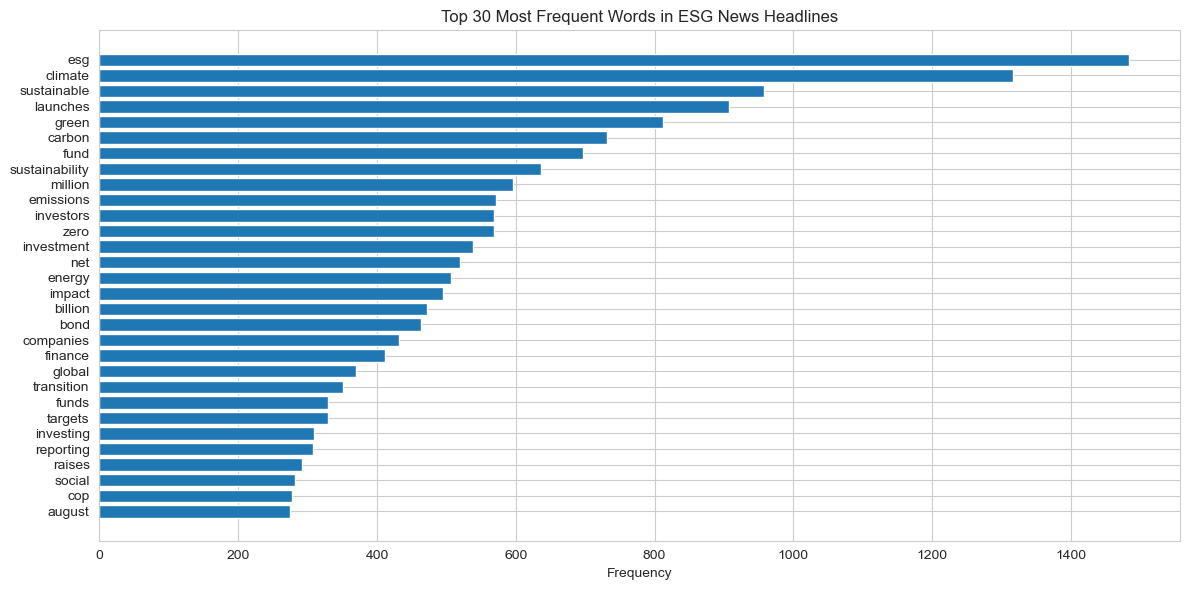

In [1]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

FILE = "merged_cleaned_20251208_174757_with_sentiment.csv"
TOP_N = 100

# Load data

df = pd.read_csv(FILE)

# Ensure headline is string
df["headline"] = df["headline"].astype(str).str.lower()

# Basic text cleaning

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)      # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)     # keep letters only
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_headline"] = df["headline"].apply(clean_text)

# Tokenize + remove stopwords

stopwords = set([
    "the","a","an","and","or","to","of","in","on","for","with","at","by",
    "from","as","is","are","was","were","be","has","have","had","will",
    "its","it","this","that","these","those","after","before","over",
    "new","says","said"
])

words = []
for text in df["clean_headline"]:
    words.extend([w for w in text.split() if w not in stopwords and len(w) > 2])

# Count top 100 words

word_counts = Counter(words)
top_words = word_counts.most_common(TOP_N)

top_df = pd.DataFrame(top_words, columns=["word", "count"])

print("\nTop 100 most frequent words in headlines:\n")
print(top_df)

# Bar chart (Top 30)

plt.figure(figsize=(12, 6))


plt.barh(
    top_df.head(30)["word"][::-1],
    top_df.head(30)["count"][::-1]
)
plt.title("Top 30 Most Frequent Words in ESG News Headlines")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

##### Sentiment Analysis

In [3]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Config

INPUT_FILE = "merged_cleaned_20251208_174757_with_sentiment.csv"
OUTPUT_FILE = "v2_merged_cleaned_20251208_174757_with_sentiment.csv"

RANDOM_STATE = 42
TEST_SIZE = 0.20

NGRAM_RANGE = (1, 3)
MIN_DF = 2
MAX_FEATURES = 5000

RF_N_ESTIMATORS = 400

# Load dataset

df = pd.read_csv(INPUT_FILE)
df["headline"] = df["headline"].astype(str).fillna("").str.strip()

#  Advanced Rule-Based Model (TEACHER)

positive_keywords = [
    "invests", "investment", "investing", "startup", "signs", "solution", "raises",
    "recycling", "restore", "clean tech", "sustainable", "regulations", "green", "bond",
    "project", "single-use", "sustainability", "footprint",
    "up skill", "waste", "nature", "decarbonize", "reduce", "capture",
    "goals", "standards", "sets", "compostable", "target",
    "reduction", "charging", "claim", "biodiversity", "enhance",
    "wind", "storage", "recovery", "development", "net", "net zero", "approves",
    "reforestation", "renewable", "ban", "scheme", "verification",
    "mandatory", "pilots", "fund", "funds", "funding", "hydrogen", "zero",
    "targets"
]

negative_keywords = [
    "fail", "failed", "cut", "climate", "drop", "reject", "delay",
    "tough", "pause", "exempt", "exit", "pressure", "paper",
    "stop", "eliminate", "overturn", "coal", "pollution", "pollute",
    "harm", "deforestation", "misleading", "extra", "hit", "war",
    "lag", "block", "threatens", "accuses", "fails", "collapse",
    "resistance", "setback", "weapon", "military", "soldier", "uncertainty"
]

neutral_keywords = [
    "vote", "voting", "commission", "negotiate", "negotiation", "appoints",
    "appointment", "flexible", "secures", "cop", "commits", "commitment", "optional",
    "transition", "certification", "regulate", "reserve", "circular", "block chain",
    "tokenization", "tax", "benchmark", "risk", "investigation", "law", "adopt",
    "link", "revenue", "launch", "open", "electric", "adaptation", "conversation",
    "debate", "address", "major", "purchase", "outlines", "publishes",
    "framework", "policy", "analysis", "survey", "study", "social", "review", "guidelines",
    "negotiations", "agreement talks", "opinion", "guest post", "research", "report",
    "impact", "finance", "global"
]

positive_keywords = [k.lower() for k in positive_keywords]
negative_keywords = [k.lower() for k in negative_keywords]
neutral_keywords = [k.lower() for k in neutral_keywords]

def rule_based_label(text: str) -> str:
    t = str(text).lower()

    pos = sum(1 for kw in positive_keywords if kw in t)
    neg = sum(1 for kw in negative_keywords if kw in t)
    neu = sum(1 for kw in neutral_keywords if kw in t)

    # PRIORITY: Negative > Positive > Neutral
    if neg > 0:
        return "Negative"
    if pos > 0:
        return "Positive"
    if neu > 0:
        return "Neutral"
    return "Neutral"

df["Rule_Based_Model_Sentiment"] = df["headline"].apply(rule_based_label)

# TF-IDF Features


X = df["headline"]
y = df["Rule_Based_Model_Sentiment"]

vectorizer = TfidfVectorizer(
    ngram_range=NGRAM_RANGE,
    min_df=MIN_DF,
    max_features=MAX_FEATURES
)
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_vec,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

# 4) Train models

models = {
    "Hybrid_LR": LogisticRegression(
        max_iter=800,
        C=1.0,
        solver="liblinear",
        multi_class="ovr"
    ),
    "Hybrid_NB": MultinomialNB(),
    "Hybrid_RF": RandomForestClassifier(
        n_estimators=RF_N_ESTIMATORS,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

# Evaluation


print("\n = MODEL COMPARISON =")

acc_table = []

for name, clf in models.items():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)

    acc = accuracy_score(y_test, pred)
    acc_table.append((name, acc))

    print(f"\n{name} Accuracy: {acc*100:.2f}%")
    print(classification_report(y_test, pred, digits=3))

print("\nAccuracy Summary:")
for name, acc in sorted(acc_table, key=lambda x: x[1], reverse=True):
    print(f"- {name}: {acc*100:.2f}%")

# Showing results and saved dataset

for name, clf in models.items():
    df[f"{name}_Sentiment"] = clf.predict(X_vec)

df.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")

print("\nSaved:", OUTPUT_FILE)
print("New columns added:")
print("- Rule_Based_Model_Sentiment")
for name in models.keys():
    print(f"- {name}_Sentiment")
print("=")


 = MODEL COMPARISON =

Hybrid_LR Accuracy: 91.28%
              precision    recall  f1-score   support

    Negative      1.000     0.742     0.852       500
     Neutral      0.882     0.957     0.918       700
    Positive      0.905     0.962     0.933      1105

    accuracy                          0.913      2305
   macro avg      0.929     0.887     0.901      2305
weighted avg      0.919     0.913     0.911      2305


Hybrid_NB Accuracy: 83.43%
              precision    recall  f1-score   support

    Negative      0.897     0.682     0.775       500
     Neutral      0.845     0.789     0.816       700
    Positive      0.810     0.932     0.867      1105

    accuracy                          0.834      2305
   macro avg      0.851     0.801     0.819      2305
weighted avg      0.840     0.834     0.831      2305



C:\Users\ozera\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Hybrid_RF Accuracy: 95.62%
              precision    recall  f1-score   support

    Negative      1.000     0.860     0.925       500
     Neutral      0.928     0.994     0.960       700
    Positive      0.958     0.976     0.967      1105

    accuracy                          0.956      2305
   macro avg      0.962     0.943     0.951      2305
weighted avg      0.958     0.956     0.956      2305


Accuracy Summary:
- Hybrid_RF: 95.62%
- Hybrid_LR: 91.28%
- Hybrid_NB: 83.43%

Saved: v2_merged_cleaned_20251208_174757_with_sentiment.csv
New columns added:
- Rule_Based_Model_Sentiment
- Hybrid_LR_Sentiment
- Hybrid_NB_Sentiment
- Hybrid_RF_Sentiment
=


##### Sentiment Distribution Across NLP Models x Year

Rows after year filter (2018-2024): 10306
Rows after sentiment cleaning: 10306


,GPT,Rule_Based,Hybrid_LR,Hybrid_NB,Hybrid_RF
Positive,1450,4902,5133,5518,4920
Neutral,8382,3210,3401,3011,3253
Negative,474,2194,1772,1777,2133



Year × Sentiment breakdown (2018–2024):


model            GPT  Hybrid_LR  Hybrid_NB  Hybrid_RF  Rule_Based
year sentiment                                                   
2018 Positive     21        144        161        144         145
     Neutral     350        198        180        171         168
     Negative     16         45         46         72          74
2019 Positive     38        227        248        226         224
     Neutral     524        292        265        274         269
     Negative     22         65         71         84          91
2020 Positive    233        849        904        807         805
     Neutral    1440        623        563        601         599
     Negative     86        287        292        351         355
2021 Positive    421       1068       1173       1033        1025
     Neutral    1690        680        603        653         647
     Negative     92        455        427        517         531
2022 Positive    320        984       1067        948         944
     Neutral    1572        618        527        589         578
     Negative     88        378        386        443         458
2023 Positive    196        894        959        861         862
     Neutral    1364        489        423        470         462
     Negative     78        255        256        307         314
2024 Positive    221        967       1006        901         897
     Neutral    1442        501        450        495         487
     Negative     92        287        299        359         371

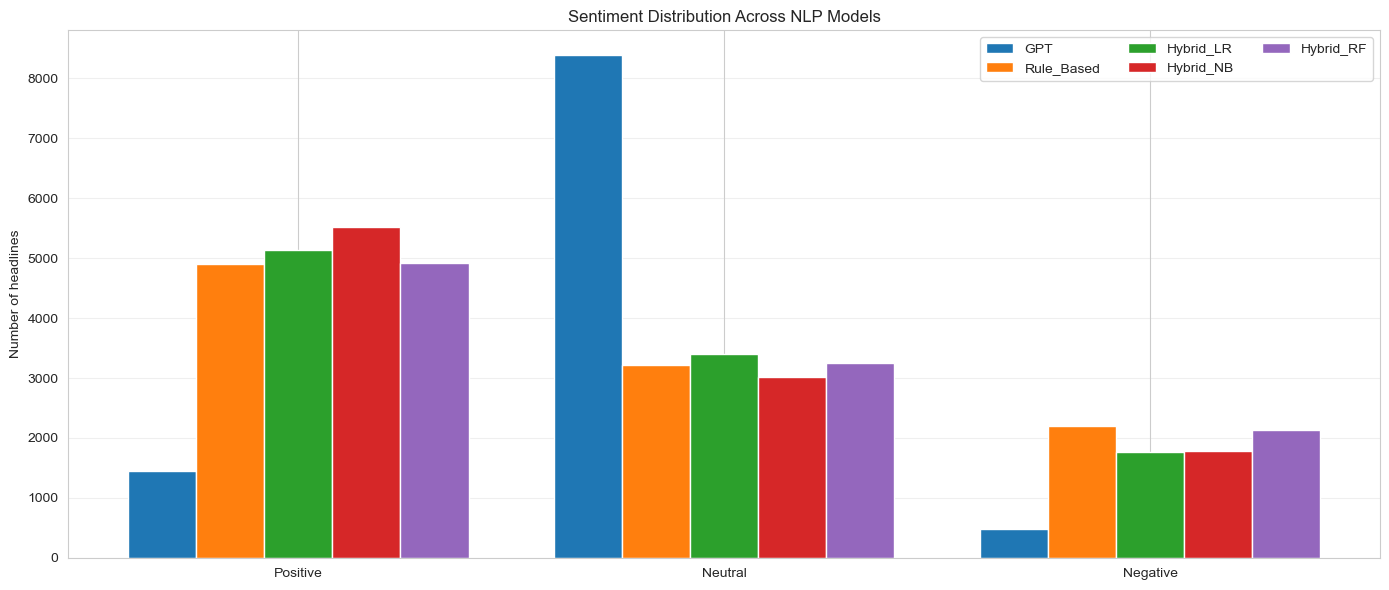

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "v2_merged_cleaned_20251208_174757_with_sentiment.csv"
START_YEAR, END_YEAR = 2018, 2024

MODEL_COLS = {
    "GPT": "GPT_sentiment",
    "Rule_Based": "Rule_Based_Model_Sentiment",
    "Hybrid_LR": "Hybrid_LR_Sentiment",
    "Hybrid_NB": "Hybrid_NB_Sentiment",
    "Hybrid_RF": "Hybrid_RF_Sentiment",
}

SENTIMENTS = ["Positive", "Neutral", "Negative"]

# Load dataset

df = pd.read_csv(FILE)

# Detect column year safety to eliminate conflicts the dates given news headlines and published years

year_col = None
for c in ["publish_year", "year", "published_year"]:
    if c in df.columns:
        year_col = c
        break
if year_col is None:
    raise ValueError("No year column found in dataset")

df[year_col] = pd.to_numeric(df[year_col], errors="coerce")
df = df[df[year_col].between(START_YEAR, END_YEAR)].copy()

print(f"Rows after year filter ({START_YEAR}-{END_YEAR}):", len(df))

# Normalize Sentiment Labels

def normalize_sentiment(x):
    x = str(x).strip().lower()
    if x.startswith("pos"):
        return "Positive"
    if x.startswith("neg"):
        return "Negative"
    if x.startswith("neu"):
        return "Neutral"
    return np.nan

# Keep only models that exist in the file
MODEL_COLS = {k: v for k, v in MODEL_COLS.items() if v in df.columns}

for col in MODEL_COLS.values():
    df[col] = df[col].apply(normalize_sentiment)

# drop rows where any model is missing
df_clean = df.dropna(subset=list(MODEL_COLS.values())).copy()
print("Rows after sentiment cleaning:", len(df_clean))

# Total Counts (2018–2024)

count_df = pd.DataFrame({
    model: df_clean[col].value_counts().reindex(SENTIMENTS, fill_value=0)
    for model, col in MODEL_COLS.items()
})

display(count_df)

# Year × Sentiment × Model

records = []
for model, col in MODEL_COLS.items():
    tmp = (
        df_clean.groupby([year_col, col])
        .size()
        .reset_index(name="count")
        .rename(columns={col: "sentiment", year_col: "year"})
    )
    tmp["model"] = model
    records.append(tmp)

long_df = pd.concat(records, ignore_index=True)

pivot_year = (
    long_df.pivot_table(
        index=["year", "sentiment"],
        columns="model",
        values="count",
        fill_value=0,
        aggfunc="sum"
    )
    .reindex(
        pd.MultiIndex.from_product(
            [range(START_YEAR, END_YEAR + 1), SENTIMENTS],
            names=["year", "sentiment"]
        ),
        fill_value=0
    )
)

print("\nYear × Sentiment breakdown (2018–2024):")
display(pivot_year)


# Plot grouped bar chart

x = np.arange(len(SENTIMENTS))
n_models = len(count_df.columns)
width = 0.8 / n_models

plt.figure(figsize=(14, 6))

for i, model_name in enumerate(count_df.columns):
    plt.bar(
        x + (i - (n_models - 1) / 2) * width,
        count_df[model_name].values,
        width,
        label=model_name
    )

plt.xticks(x, SENTIMENTS)
plt.ylabel("Number of headlines")
plt.title("Sentiment Distribution Across NLP Models")
plt.legend(ncol=3)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


##### Yearly ESG News Sentiment by Category (Hybrid_LR)

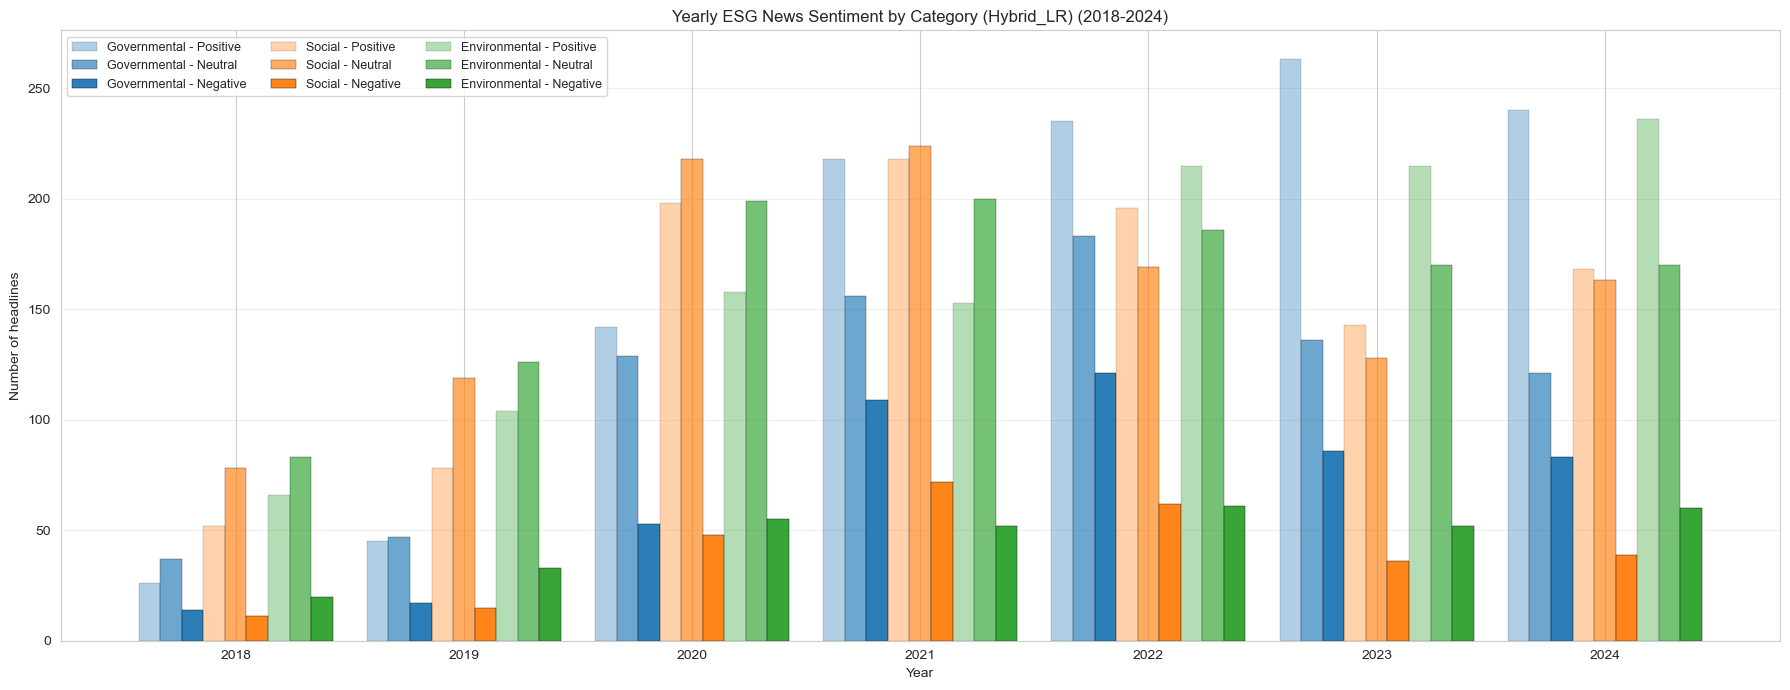

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "v2_merged_cleaned_20251208_174757_with_sentiment.csv"
START_YEAR, END_YEAR = 2018, 2024

CATEGORIES = ["governmental", "social", "environmental"]
SENTIMENTS = ["Positive", "Neutral", "Negative"]
SENTIMENT_COL = "Hybrid_LR_Sentiment"


# Load & clean dateset

df = pd.read_csv(FILE)
cat_col = "category_name" if "category_name" in df.columns else "category"

df["publish_year"] = pd.to_numeric(df["publish_year"], errors="coerce")
df = df[df["publish_year"].between(START_YEAR, END_YEAR)].copy()

df[cat_col] = (
    df[cat_col].astype(str).str.strip().str.lower()
).replace({"governance": "governmental", "government": "governmental"})

df = df[df[cat_col].isin(CATEGORIES)].copy()

def normalize_sentiment(x):
    x = str(x).strip().lower()
    if x.startswith("pos"):
        return "Positive"
    if x.startswith("neg"):
        return "Negative"
    return "Neutral"

df[SENTIMENT_COL] = df[SENTIMENT_COL].apply(normalize_sentiment)


# Aggregate: year x category x sentiment

years = list(range(START_YEAR, END_YEAR + 1))

agg = (
    df.groupby(["publish_year", cat_col, SENTIMENT_COL])
      .size()
      .reset_index(name="count")
)

pivot = agg.pivot_table(
    index=["publish_year", cat_col],
    columns=SENTIMENT_COL,
    values="count",
    fill_value=0,
    aggfunc="sum"
).reset_index()

for s in SENTIMENTS:
    if s not in pivot.columns:
        pivot[s] = 0

# fill missing year

full_index = pd.MultiIndex.from_product([years, CATEGORIES], names=["publish_year", cat_col])
pivot = pivot.set_index(["publish_year", cat_col]).reindex(full_index, fill_value=0).reset_index()


# Plot grouped bars 

x_year = np.arange(len(years))

# categories per year

n_cat = len(CATEGORIES)
n_sent = len(SENTIMENTS)

group_width = 0.85
bar_w = group_width / (n_cat * n_sent)

# choose base colors (category) and sentiment shades

cat_base = {
    "governmental": "C0",
    "social": "C1",
    "environmental": "C2"
}
alpha_by_sent = {
    "Positive": 0.35,
    "Neutral": 0.65,
    "Negative": 0.95
}

plt.figure(figsize=(18, 7))

for ci, cat in enumerate(CATEGORIES):
    sub = pivot[pivot[cat_col] == cat].sort_values("publish_year")

    for si, sent in enumerate(SENTIMENTS):
        # offset within each year block
        idx_in_block = ci * n_sent + si
        offset = (idx_in_block - (n_cat * n_sent - 1) / 2) * bar_w

        plt.bar(
            x_year + offset,
            sub[sent].values,
            width=bar_w,
            color=cat_base[cat],
            alpha=alpha_by_sent[sent],
            edgecolor="black",
            linewidth=0.3,
            label=f"{cat.capitalize()} - {sent}"
        )

plt.title(f"Yearly ESG News Sentiment by Category (Hybrid_LR) ({START_YEAR}-{END_YEAR})")
plt.xlabel("Year")
plt.ylabel("Number of headlines")
plt.xticks(x_year, years)
plt.grid(axis="y", alpha=0.3)


handles, labels = plt.gca().get_legend_handles_labels()
seen = set()
h2, l2 = [], []
for h, l in zip(handles, labels):
    if l not in seen:
        h2.append(h); l2.append(l); seen.add(l)

plt.legend(h2, l2, ncol=3, fontsize=9, loc="upper left")
plt.tight_layout()
plt.show()

##### Scaling Sentiment Scores (Weighted Average Score)


Yearly Avg Sentiment Score (25/50/75) — 2018–2024


Model,GPT,Hybrid_LR,Hybrid_NB,Hybrid_RF,Rule_Based
Year,,,,,
2018,50.32,56.40,57.43,54.65,54.59
2019,50.68,56.93,57.58,56.08,55.69
2020,52.09,57.99,58.70,56.48,56.40
2021,53.73,56.96,58.47,55.86,55.61
2022,52.93,57.65,58.60,56.38,56.14
2023,51.80,59.75,60.73,58.46,58.36
2024,51.84,59.69,60.07,57.72,57.49


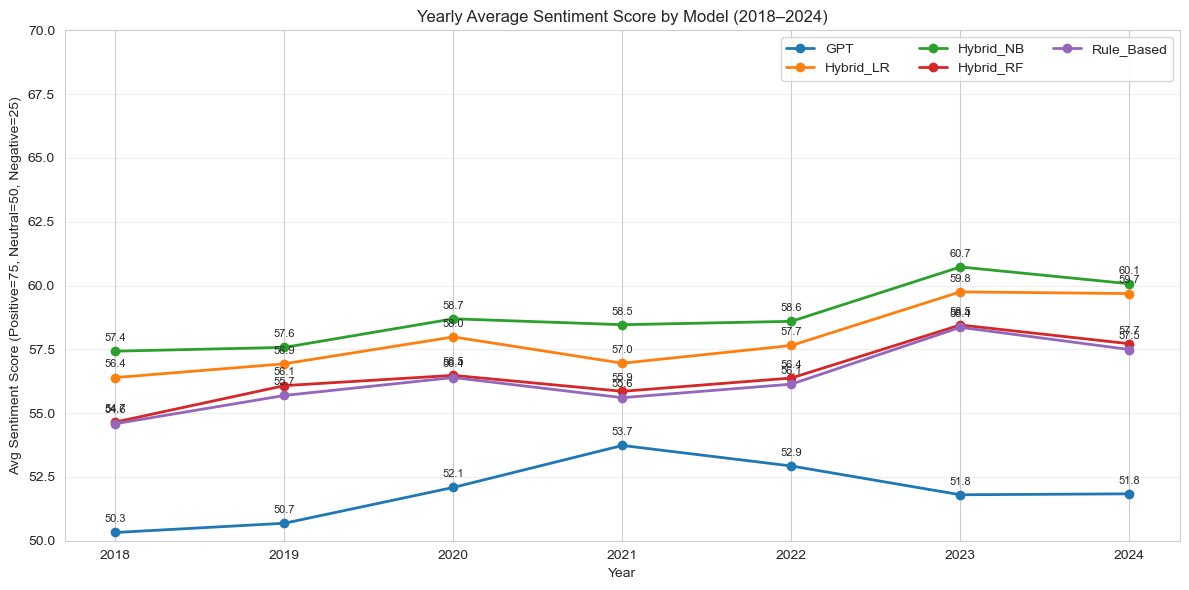

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "v2_merged_cleaned_20251208_174757_with_sentiment.csv"
START_YEAR, END_YEAR = 2018, 2024
YEARS = list(range(START_YEAR, END_YEAR + 1))

SENTIMENT_SCORE = {"Positive": 75, "Neutral": 50, "Negative": 25}

# Choose model columns 
CANDIDATE_MODEL_COLS = {

    "GPT": "GPT_sentiment",
    "Rule_Based": "Rule_Based_Model_Sentiment",
    "Hybrid_LR": "Hybrid_LR_Sentiment",
    "Hybrid_NB": "Hybrid_NB_Sentiment",
    "Hybrid_RF": "Hybrid_RF_Sentiment",
}

def normalize_sentiment(x):
    x = str(x).strip().lower()
    if x.startswith("pos"):
        return "Positive"
    if x.startswith("neg"):
        return "Negative"
    if x.startswith("neu"):
        return "Neutral"
    return np.nan

df = pd.read_csv(FILE)

# cleaning publish_year column (string or float)

df["publish_year"] = pd.to_numeric(df.get("publish_year"), errors="coerce")
df = df[df["publish_year"].between(START_YEAR, END_YEAR)].copy()


MODEL_COLS = {k: v for k, v in CANDIDATE_MODEL_COLS.items() if v in df.columns}
if not MODEL_COLS:
    raise ValueError("Control columns")

# normalize sentiments

for col in MODEL_COLS.values():
    df[col] = df[col].apply(normalize_sentiment)

# chose right model columns + standardized year metric

rows = []
for model_name, col in MODEL_COLS.items():
    sub = df.dropna(subset=[col]).copy()
    sub["sentiment_score"] = sub[col].map(SENTIMENT_SCORE)

    yearly_avg = (
        sub.groupby("publish_year")["sentiment_score"]
           .mean()
           .reindex(YEARS)
    )

    tmp = pd.DataFrame({
        "Year": YEARS,
        "Model": model_name,
        "Avg_Sentiment_Score": yearly_avg.values
    })
    rows.append(tmp)

out = pd.concat(rows, ignore_index=True)

# Pivot table

pivot = out.pivot_table(index="Year", columns="Model", values="Avg_Sentiment_Score", aggfunc="mean")

print("\nYearly Avg Sentiment Score (25/50/75) — 2018–2024")
display(pivot.round(2))

# Plot model

plt.figure(figsize=(12, 6))

for model in pivot.columns:
    plt.plot(pivot.index, pivot[model], marker="o", linewidth=2, label=model)

    # value labels
    for y in pivot.index:
        v = pivot.loc[y, model]
        if pd.notna(v):
            plt.text(y, v + 0.4, f"{v:.1f}", ha="center", fontsize=8)

plt.title("Yearly Average Sentiment Score by Model (2018–2024)")
plt.xlabel("Year")
plt.ylabel("Avg Sentiment Score (Positive=75, Neutral=50, Negative=25)")
plt.ylim(50, 70)  # reasonable quote
plt.xticks(YEARS)
plt.grid(axis="y", alpha=0.3)
plt.legend(ncol=3)
plt.tight_layout()
plt.show()

##### Nominal Broad U.S. Dollar Index (DTWEXBGS) Adjustment
##### Index Jan 2006=100 => avarege NBUS calculated with taking overall U:S dollar index calculated // take overall first day and last day index by years
##### Green Bond Investments

Total bond investment (2018–2024): 45,094.47 $B


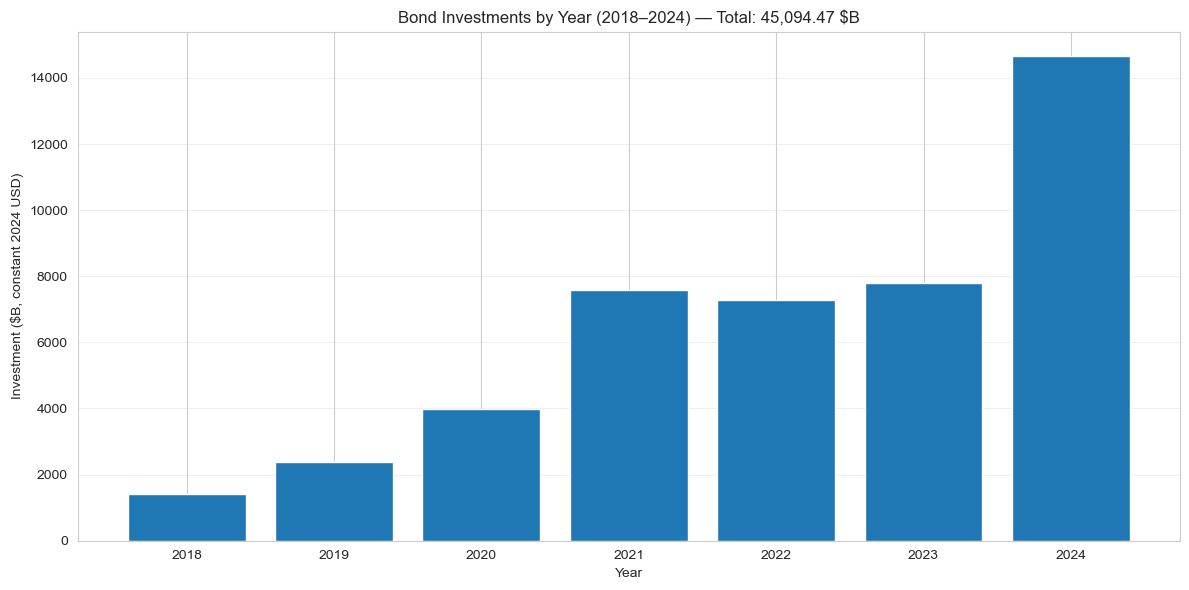


Total by Bond_Type (2018–2024):
Bond_Type
GBP     26,707.98
SBP      6,952.57
SBG      8,556.53
SLBP     2,659.99
dtype: object


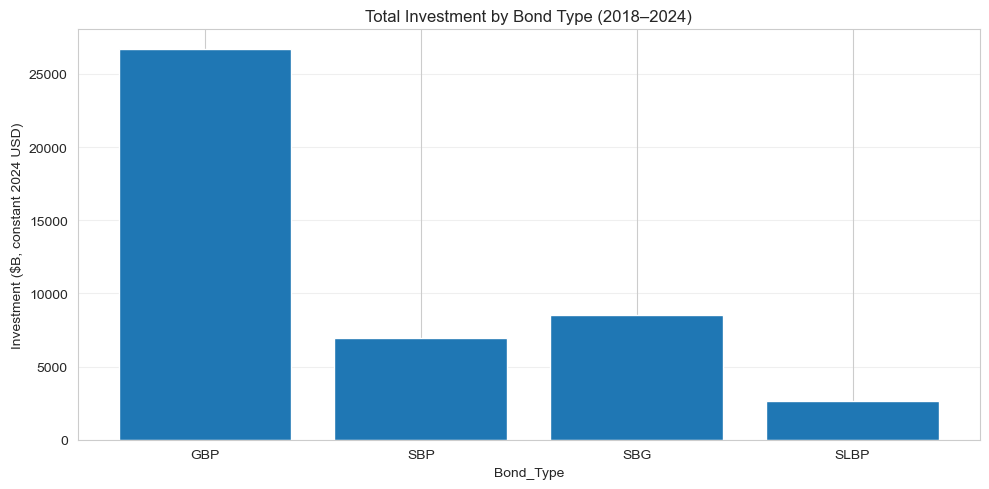

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file = "Green_Bonds.csv"
start_year, end_year = 2018, 2024
year_cols = [str(y) for y in range(start_year, end_year + 1)]
target_types = ["GBP", "SBP", "SBG", "SLBP"]

# read csv
df = pd.read_csv(file, encoding="latin1")

# rename year headings
df = df.rename(columns={
    "F2018": "2018",
    "F2019": "2019",
    "F2020": "2020",
    "F2021": "2021",
    "F2022": "2022",
    "F2023": "2023",
    "F2024": "2024",
})

# validate
missing_years = [c for c in year_cols if c not in df.columns]
if missing_years:
    raise ValueError(f"Missing year columns in CSV after rename: {missing_years}")
if "Bond_Type" not in df.columns:
    raise ValueError("Missing required column: Bond_Type")

# bond_Type normalize (keep blanks)
df["Bond_Type"] = (
    df["Bond_Type"]
    .fillna("")
    .astype(str)
    .str.strip()
    .str.upper()
)

# bond type mapping
bond_type_map = {
    # ICMA full names
    "GREEN BOND PRINCIPLES": "GBP",
    "SOCIAL BOND PRINCIPLES": "SBP",
    "SUSTAINABILITY BOND GUIDELINES": "SBG",
    "SUSTAINABILITY-LINKED BOND PRINCIPLES": "SLBP",

    # common short labels found in datasets
    "GREEN BOND": "GBP",
    "GREEN BONDS": "GBP",
    "SOCIAL BOND": "SBP",
    "SUSTAINABILITY BOND": "SBG",      
    "SUSTAINABILITY-LINKED BOND": "SLBP",
    "LINKED BOND": "SLBP",

    "GBP": "GBP",
    "SBP": "SBP",
    "SBG": "SBG",
    "SLBP": "SLBP",
}

df["Bond_Type"] = df["Bond_Type"].replace(bond_type_map)

for c in year_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

# NBUS adjustment
nbus = {
    2018: 112.60555,
    2019: 115.21865,
    2020: 113.1493,
    2021: 113.2556,
    2022: 118.43175,
    2023: 120.4265,
    2024: 124.55225
}
base_nbus = nbus[2024]
for y in year_cols:
    df[y] = df[y] * (base_nbus / nbus[int(y)])

fmt2 = lambda x: f"{x:,.2f}"

# Total investment

yearly_totals = df[year_cols].sum(axis=0)
total_2018_2024 = yearly_totals.sum()

print(f"Total bond investment (2018–2024): {fmt2(total_2018_2024)} $B")

plt.figure(figsize=(12, 6))
plt.bar([int(y) for y in year_cols], yearly_totals.values)
plt.xlabel("Year")
plt.ylabel("Investment ($B, constant 2024 USD)")
plt.title(
    f"Bond Investments by Year (2018–2024) — Total: {fmt2(total_2018_2024)} $B"
)
plt.grid(axis="y", alpha=0.3)
plt.xticks([int(y) for y in year_cols])
plt.tight_layout()
plt.show()

# celar NAN values
df = df[df["Bond_Type"] != ""]


df_types = df[df["Bond_Type"].isin(target_types)]

type_year = df_types.groupby("Bond_Type")[year_cols].sum()
type_total = type_year.sum(axis=1)


type_total = type_total.reindex(target_types).fillna(0.0)

print("\nTotal by Bond_Type (2018–2024):")
print(type_total.round(2).apply(fmt2))

plt.figure(figsize=(10, 5))
plt.bar(type_total.index, type_total.values)
plt.xlabel("Bond_Type")
plt.ylabel("Investment ($B, constant 2024 USD)")
plt.title("Total Investment by Bond Type (2018–2024)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


##### ESG Overall by Region


ESG Overall Score – Region Summary (2018–2024)


,Region,Count,Min,Max,Mean,Median,Mode,Q1,Q3,IQR,Outlier_Count
0,Middle East,1029,8.5,80.8,44.05,43.80,40.3,33.80,52.80,19.00,0
1,Africa,931,16.1,79.4,45.19,46.30,37.2,35.90,54.00,18.10,0
2,Latin America,959,11.6,95.9,51.19,51.80,56.4,43.70,59.80,16.10,28
3,Asia,1064,20.8,88.8,52.59,52.50,47.6,43.18,62.40,19.22,0
4,Oceania,1057,25.6,93.9,63.04,62.40,65.0,54.00,73.00,19.00,0
5,North America,980,26.5,93.4,61.84,62.65,65.3,53.45,71.03,17.58,1
6,Europe,980,30.5,98.8,68.45,68.70,78.1,59.75,77.00,17.25,3


<Figure size 1400x600 with 0 Axes>

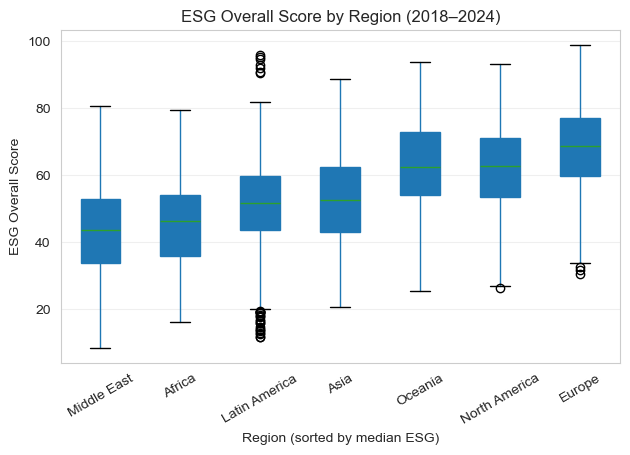

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "company_esg_financial_dataset.csv"
START_YEAR, END_YEAR = 2018, 2024

df = pd.read_csv(FILE)

# Filtering & cleaning dataset

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df[df["Year"].between(START_YEAR, END_YEAR)]

df["Region"] = df["Region"].astype(str).str.strip()
df["ESG_Overall"] = pd.to_numeric(df["ESG_Overall"], errors="coerce")
df = df.dropna(subset=["Region", "ESG_Overall"])

# Region order (median-based)

region_order = (
    df.groupby("Region")["ESG_Overall"]
      .median()
      .sort_values()
      .index
      .tolist()
)

df["Region"] = pd.Categorical(
    df["Region"],
    categories=region_order,
    ordered=True
)

# Summary

summary = []

for region in region_order:
    sub = df[df["Region"] == region]["ESG_Overall"]

    q1 = sub.quantile(0.25)
    q3 = sub.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = ((sub < lower) | (sub > upper)).sum()

    mode_val = sub.mode()
    mode_val = mode_val.iloc[0] if not mode_val.empty else np.nan

    summary.append({
        "Region": region,
        "Count": len(sub),
        "Min": round(sub.min(), 2),
        "Max": round(sub.max(), 2),
        "Mean": round(sub.mean(), 2),
        "Median": round(sub.median(), 2),
        "Mode": round(mode_val, 2),
        "Q1": round(q1, 2),
        "Q3": round(q3, 2),
        "IQR": round(iqr, 2),
        "Outlier_Count": int(outliers)
    })

summary_df = pd.DataFrame(summary)

print("\nESG Overall Score – Region Summary (2018–2024)")
display(summary_df)

# Plotting

plt.figure(figsize=(14, 6))
df.boxplot(
    column="ESG_Overall",
    by="Region",
    grid=False,
    patch_artist=True,
    showfliers=True
)

plt.title("ESG Overall Score by Region (2018–2024)")
plt.suptitle("")
plt.xlabel("Region (sorted by median ESG)")
plt.ylabel("ESG Overall Score")
plt.xticks(rotation=30)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


##### ESG Overall by Industry


ESG Overall Score – Industry Summary (2018–2024)


,Industry,Count,Min,Max,Mean,Median,Mode,Q1,Q3,IQR,Outlier_Count
0,Transportation,819,13.9,80.3,46.70,48.20,51.7,35.50,56.30,20.80,0
1,Energy,756,11.6,85.1,49.76,49.70,42.4,40.48,60.00,19.52,0
2,Manufacturing,819,22.0,92.4,51.12,50.40,45.1,40.20,61.60,21.40,0
3,Utilities,749,17.1,93.4,52.23,52.50,45.8,42.70,62.10,19.40,3
4,Consumer Goods,812,8.5,94.7,55.51,56.25,60.5,46.18,66.00,19.82,14
5,Retail,742,16.6,92.8,56.42,57.15,68.1,46.90,67.00,20.10,1
6,Healthcare,847,22.2,96.3,57.85,58.80,47.7,48.30,67.85,19.55,0
7,Technology,665,28.9,94.7,63.85,64.20,60.3,53.70,73.70,20.00,0
8,Finance,791,33.5,98.8,65.13,64.60,62.4,54.40,75.45,21.05,0


<Figure size 1800x700 with 0 Axes>

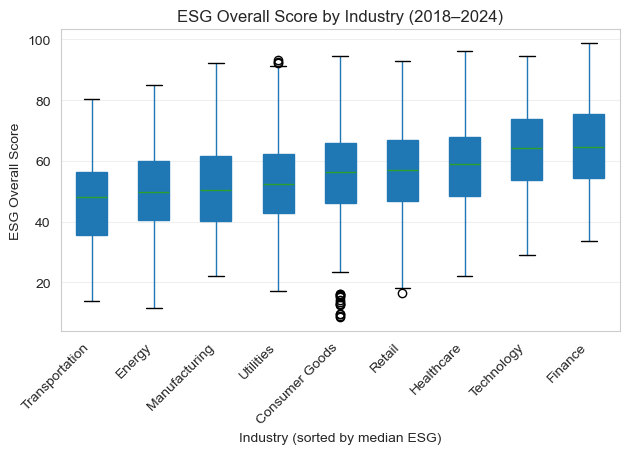

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "company_esg_financial_dataset.csv"
START_YEAR, END_YEAR = 2018, 2024

df = pd.read_csv(FILE)


# Filtering & cleaning dataset

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df[df["Year"].between(START_YEAR, END_YEAR)].copy()

df["Industry"] = df["Industry"].astype(str).str.strip()
df["ESG_Overall"] = pd.to_numeric(df["ESG_Overall"], errors="coerce")
df = df.dropna(subset=["Industry", "ESG_Overall"]).copy()


# Sort Industries by median ESG

industry_order = (
    df.groupby("Industry")["ESG_Overall"]
      .median()
      .sort_values()
      .index
      .tolist()
)

df["Industry"] = pd.Categorical(
    df["Industry"],
    categories=industry_order,
    ordered=True
)

# Summary

summary = []

for ind in industry_order:
    sub = df[df["Industry"] == ind]["ESG_Overall"]

    q1 = sub.quantile(0.25)
    q3 = sub.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = ((sub < lower) | (sub > upper)).sum()

    mode_val = sub.mode()
    mode_val = mode_val.iloc[0] if not mode_val.empty else np.nan

    summary.append({
        "Industry": ind,
        "Count": len(sub),
        "Min": round(sub.min(), 2),
        "Max": round(sub.max(), 2),
        "Mean": round(sub.mean(), 2),
        "Median": round(sub.median(), 2),
        "Mode": round(mode_val, 2),
        "Q1": round(q1, 2),
        "Q3": round(q3, 2),
        "IQR": round(iqr, 2),
        "Outlier_Count": int(outliers)
    })

summary_df = pd.DataFrame(summary)

print("\nESG Overall Score – Industry Summary (2018–2024)")
display(summary_df)

# Plotting

plt.figure(figsize=(18, 7))
df.boxplot(
    column="ESG_Overall",
    by="Industry",
    grid=False,
    patch_artist=True,
    showfliers=True
)

plt.title("ESG Overall Score by Industry (2018–2024)")
plt.suptitle("")
plt.xlabel("Industry (sorted by median ESG)")
plt.ylabel("ESG Overall Score")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


##### Average ESG Score by Year


Average ESG Scores by Year (0–100)


,ESG_Environmental,ESG_Social,ESG_Governance,ESG_Overall
Year,,,,
2018,54.58,54.58,50.90,53.35
2019,55.48,55.03,51.20,53.91
2020,56.40,55.70,51.66,54.59
2021,57.26,56.25,52.21,55.24
2022,58.30,56.72,52.74,55.92
2023,59.24,57.29,53.23,56.59
2024,60.11,57.76,53.67,57.18


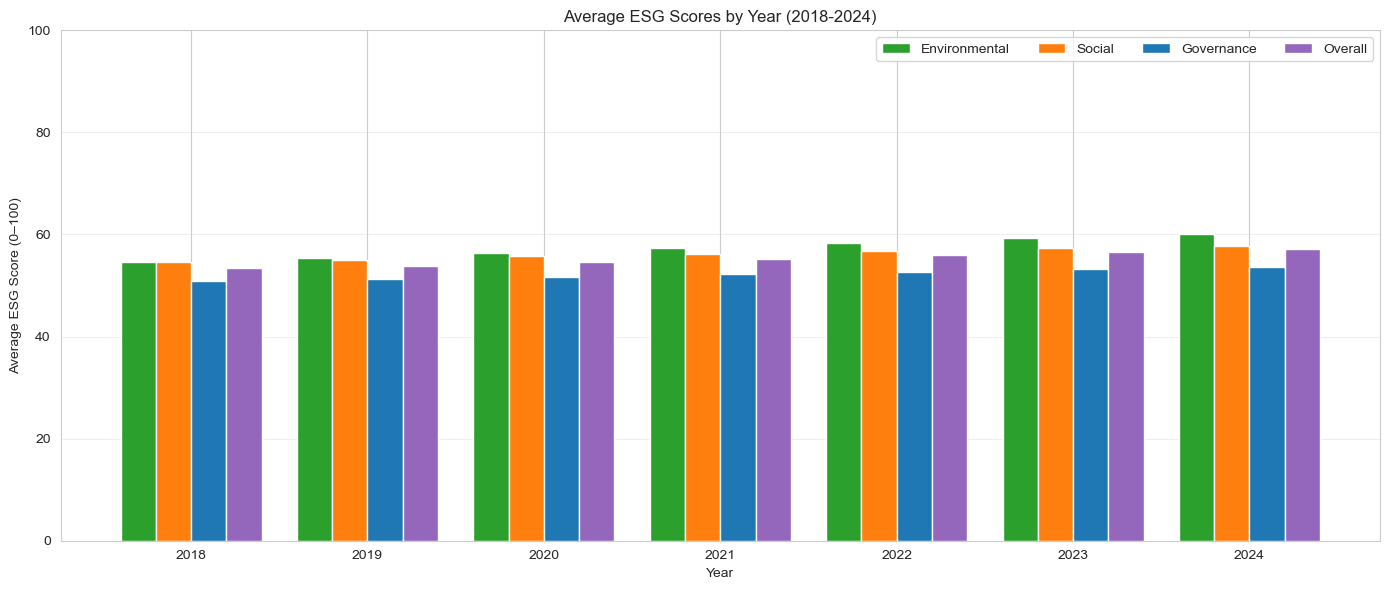

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "company_esg_financial_dataset.csv"
START_YEAR, END_YEAR = 2018, 2024

df = pd.read_csv(FILE)

# Filter years + clean

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df[df["Year"].between(START_YEAR, END_YEAR)].copy()

esg_cols = ["ESG_Environmental", "ESG_Social", "ESG_Governance", "ESG_Overall"]
for c in esg_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["Year"] + esg_cols).copy()

# Clip to 0-100
for c in esg_cols:
    df[c] = df[c].clip(lower=0, upper=100)

# Yearly mean table

years = list(range(START_YEAR, END_YEAR + 1))
yearly = (
    df.groupby("Year")[esg_cols]
      .mean()
      .reindex(years)
)

# round for display
yearly_tbl = yearly.round(2)

print("\nAverage ESG Scores by Year (0–100)")
display(yearly_tbl)

# Bar chart

x = np.arange(len(years))
w = 0.20

# color segments

COLORS = {
    "ESG_Environmental": "#2ca02c",  
    "ESG_Social": "#ff7f0e",         
    "ESG_Governance": "#1f77b4",     
    "ESG_Overall": "#9467bd"         
}

plt.figure(figsize=(14, 6))

plt.bar(x - 1.5*w, yearly["ESG_Environmental"], width=w, color=COLORS["ESG_Environmental"], label="Environmental")
plt.bar(x - 0.5*w, yearly["ESG_Social"],        width=w, color=COLORS["ESG_Social"],        label="Social")
plt.bar(x + 0.5*w, yearly["ESG_Governance"],    width=w, color=COLORS["ESG_Governance"],    label="Governance")
plt.bar(x + 1.5*w, yearly["ESG_Overall"],       width=w, color=COLORS["ESG_Overall"],       label="Overall")

plt.title(f"Average ESG Scores by Year ({START_YEAR}-{END_YEAR})")
plt.xlabel("Year")
plt.ylabel("Average ESG Score (0–100)")
plt.ylim(0, 100)
plt.xticks(x, years)
plt.grid(axis="y", alpha=0.3)
plt.legend(ncol=4)
plt.tight_layout()
plt.show()

##### YoY Change Overall Corporate ESG Score

In [22]:
import pandas as pd
import numpy as np

COMP_FILE = "company_esg_financial_dataset.csv"
START_YEAR, END_YEAR = 2018, 2024
YEARS = list(range(START_YEAR, END_YEAR + 1))

df = pd.read_csv(COMP_FILE)

# Clean + filter

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df[df["Year"].between(START_YEAR, END_YEAR)].copy()

esg_cols = ["ESG_Environmental", "ESG_Social", "ESG_Governance", "ESG_Overall"]
for c in esg_cols:
    if c not in df.columns:
        raise ValueError(f"Missing column in dataset: {c}")
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["Year"] + esg_cols).copy()

# keep scores in 0-100
for c in esg_cols:
    df[c] = df[c].clip(0, 100)

# Yearly averages

yearly_avg = (
    df.groupby("Year")[esg_cols]
      .mean()
      .reindex(YEARS)
      .round(2)
)

# YoY % change for ESG_Overall only

overall_yoy = (yearly_avg["ESG_Overall"].pct_change() * 100).round(2)
yearly_avg["Overall_YoY_%_Change"] = overall_yoy

# nicer column names (optional)
yearly_avg = yearly_avg.rename(columns={
    "ESG_Environmental": "Environmental",
    "ESG_Social": "Social",
    "ESG_Governance": "Governance",
    "ESG_Overall": "Overall_Corporate_ESG_Score"
})

yearly_avg


,Environmental,Social,Governance,Overall_Corporate_ESG_Score,Overall_YoY_%_Change
Year,,,,,
2018,54.58,54.58,50.90,53.35,NaN
2019,55.48,55.03,51.20,53.91,1.05
2020,56.40,55.70,51.66,54.59,1.26
2021,57.26,56.25,52.21,55.24,1.19
2022,58.30,56.72,52.74,55.92,1.23
2023,59.24,57.29,53.23,56.59,1.20
2024,60.11,57.76,53.67,57.18,1.04


##### YoY Change Overall ESG Sentiment Score

In [2]:
import pandas as pd
import numpy as np

NEWS_FILE = "v2_merged_cleaned_20251208_174757_with_sentiment.csv"
START_YEAR, END_YEAR = 2018, 2024
YEARS = list(range(START_YEAR, END_YEAR + 1))

SENTIMENT_SCORE = {"Positive": 75, "Neutral": 50, "Negative": 25}
CATS = ["environmental", "social", "governmental"]

def normalize_sentiment(x):
    x = str(x).strip().lower()
    if x.startswith("pos"):
        return "Positive"
    if x.startswith("neg"):
        return "Negative"
    if x.startswith("neu"):
        return "Neutral"
    return np.nan

def normalize_category(x):
    x = str(x).strip().lower()
    if x in ["governance", "government"]:
        return "governmental"
    return x

df = pd.read_csv(NEWS_FILE)

cat_col = "category_name" if "category_name" in df.columns else "category"

df["publish_year"] = pd.to_numeric(df["publish_year"], errors="coerce")
df = df[df["publish_year"].between(START_YEAR, END_YEAR)].copy()

df[cat_col] = df[cat_col].apply(normalize_category)
df = df[df[cat_col].isin(CATS)].copy()

df["Hybrid_LR_Sentiment"] = df["Hybrid_LR_Sentiment"].apply(normalize_sentiment)
df = df.dropna(subset=["Hybrid_LR_Sentiment"]).copy()

df["Sentiment_Score"] = df["Hybrid_LR_Sentiment"].map(SENTIMENT_SCORE)

# Yearly average sentiment score PER CATEGORY

yearly_cat = (
    df.groupby(["publish_year", cat_col])["Sentiment_Score"]
      .mean()
      .unstack(cat_col)
      .reindex(YEARS)
)

# Ensure all categories exist as columns
for c in CATS:
    if c not in yearly_cat.columns:
        yearly_cat[c] = np.nan

# Rename columns
yearly_cat = yearly_cat.rename(columns={
    "environmental": "Environmental",
    "social": "Social",
    "governmental": "Governance"
}).round(2)


# Overall (E+S+G combined) yearly average + YoY%

overall_yearly = (
    df.groupby("publish_year")["Sentiment_Score"]
      .mean()
      .reindex(YEARS)
)

yearly_cat["Overall_Sentiment_ESG_Score"] = overall_yearly.round(2)
yearly_cat["Overall_YoY_%_Change"] = (overall_yearly.pct_change() * 100).round(2)

yearly_cat


category,Environmental,Governance,Social,Overall_Sentiment_ESG_Score,Overall_YoY_%_Change
publish_year,,,,,
2018,56.80,53.90,57.27,56.40,NaN
2019,56.75,56.42,57.43,56.93,0.96
2020,56.25,56.87,58.08,57.12,0.33
2021,56.23,55.64,57.10,56.35,-1.36
2022,58.33,55.29,57.85,57.04,1.22
2023,59.32,59.12,58.71,59.09,3.60
2024,59.44,58.84,58.72,59.02,-0.12


##### Correlation Heatmap

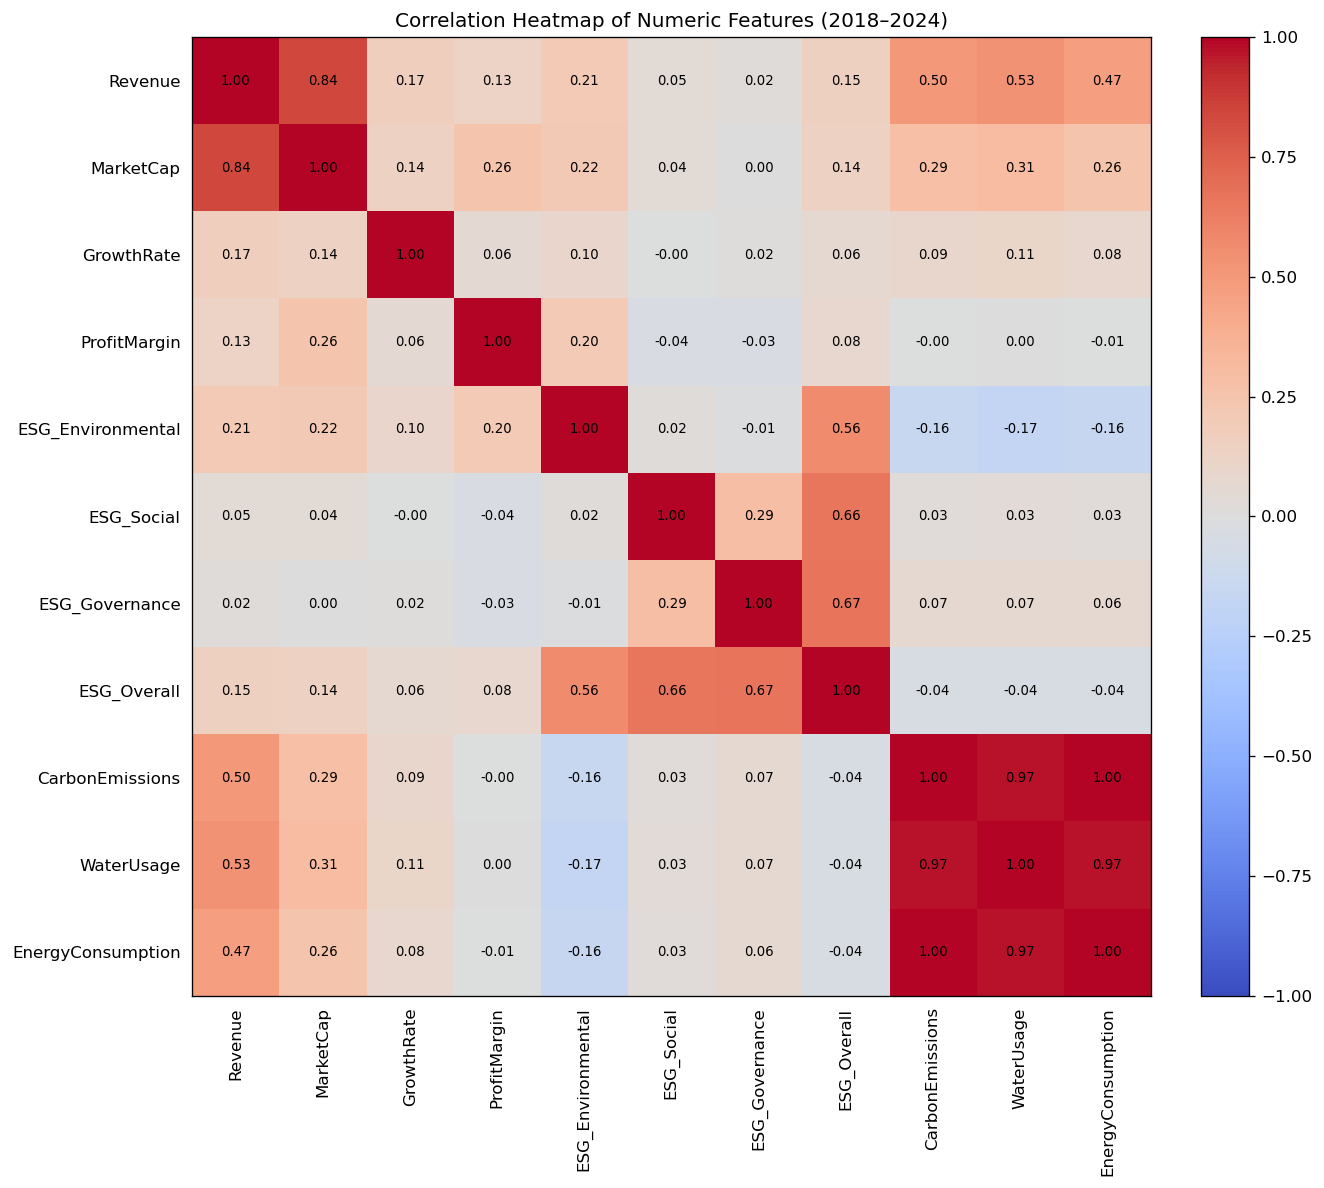

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file = "company_esg_financial_dataset.csv"
start_year, end_year = 2018, 2024

# clear rendering 

plt.close("all")
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 120

df = pd.read_csv(file)
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df[df["Year"].between(start_year, end_year)].copy()

numeric_cols = [
    "Revenue", "MarketCap", "GrowthRate", "ProfitMargin",
    "ESG_Environmental", "ESG_Social", "ESG_Governance", "ESG_Overall",
    "CarbonEmissions", "WaterUsage", "EnergyConsumption"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df_num = df[numeric_cols].dropna()
corr = df_num.corr(method="pearson")

# Heatmap
fig, ax = plt.subplots(figsize=(12, 10))

data = corr.values
n = data.shape[0]


mesh = ax.pcolormesh(
    np.arange(n + 1), np.arange(n + 1), data,
    cmap="coolwarm", vmin=-1, vmax=1,
    shading="flat",
    edgecolors="none", linewidth=0,
    antialiased=False
)
mesh.set_rasterized(True) 

ax.set_aspect("equal")
ax.invert_yaxis()  #

ax.set_xticks(np.arange(n) + 0.5)
ax.set_yticks(np.arange(n) + 0.5)
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.index)

ax.tick_params(which="both", bottom=False, left=False)
ax.set_title(f"Correlation Heatmap of Numeric Features ({start_year}–{end_year})")

cbar = fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04)

# Plot

for i in range(n):
    for j in range(n):
        ax.text(j + 0.5, i + 0.5, f"{data[i, j]:.2f}", ha="center", va="center", fontsize=8)

fig.tight_layout()
plt.show()
plt.close(fig)


##### Revunue by ESG log scale

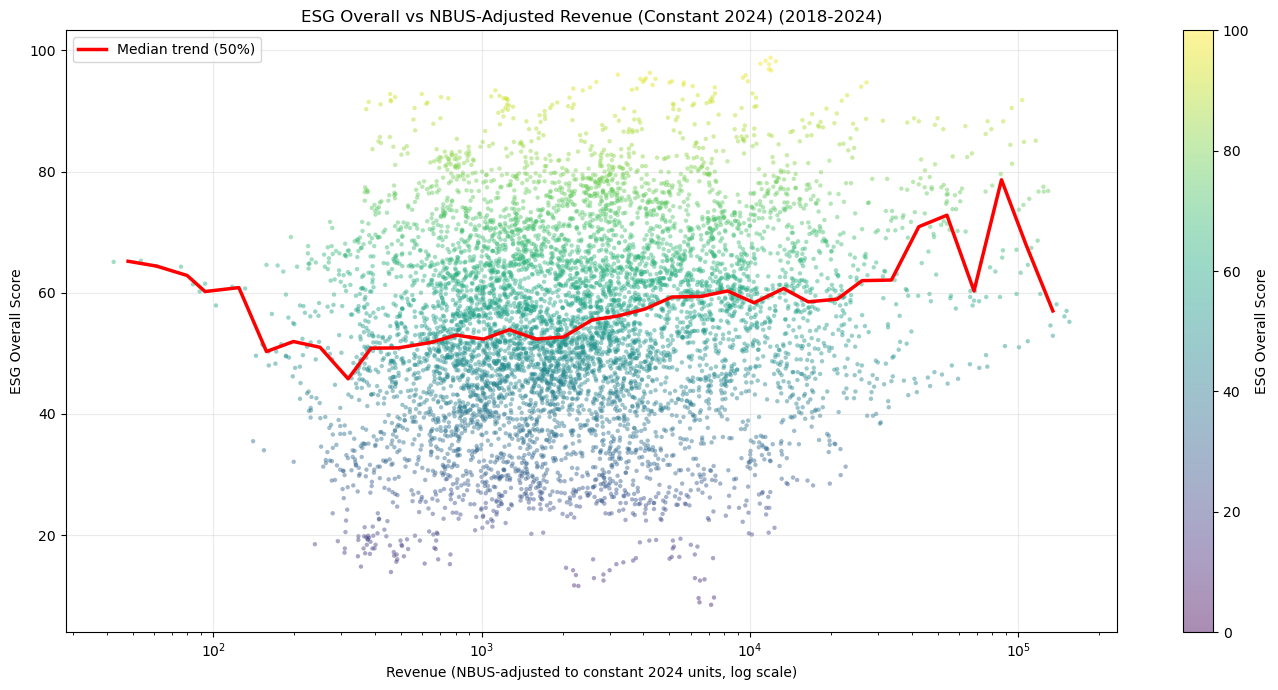

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


plt.close("all")
plt.rcdefaults()
plt.rcParams["image.cmap"] = "viridis"   

file = "company_esg_financial_dataset.csv"
start_year, end_year = 2018, 2024

nbus = {
    2018: 112.60555,
    2019: 115.21865,
    2020: 113.1493,
    2021: 113.2556,
    2022: 118.43175,
    2023: 120.4265,
    2024: 124.55225
}

df = pd.read_csv(file)

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df[df["Year"].between(start_year, end_year)].copy()

for c in ["Revenue", "ESG_Overall"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["Year", "Revenue", "ESG_Overall"])

df["NBUS"] = df["Year"].map(nbus)
if df["NBUS"].isna().any():
    bad_years = sorted(df.loc[df["NBUS"].isna(), "Year"].unique())
    raise ValueError(f"NBUS missing for years: {bad_years}")

df["Revenue_Real_2024"] = df["Revenue"] * (nbus[2024] / df["NBUS"])
df = df[df["Revenue_Real_2024"] > 0].copy()

x = df["Revenue_Real_2024"].values
y = df["ESG_Overall"].values

# Median (50%) trend: revenue-binned median ESG

logx = np.log10(x)
n_bins = 35
bins = np.linspace(logx.min(), logx.max(), n_bins + 1)
df["_bin"] = pd.cut(logx, bins=bins, include_lowest=True)

binned = (
    df.groupby("_bin", observed=False)  
      .agg(rev_median=("Revenue_Real_2024", "median"),
           esg_median=("ESG_Overall", "median"))
      .dropna()
      .sort_values("rev_median")
)

plt.figure(figsize=(14, 7))

sc = plt.scatter(
    x, y,
    c=y,
    cmap="viridis",      
    vmin=0, vmax=100,    
    s=10,
    alpha=0.45,
    linewidths=0
)

# Formatting

cbar = plt.colorbar(sc)
cbar.set_label("ESG Overall Score")

plt.plot(
    binned["rev_median"].values,
    binned["esg_median"].values,
    color="red",
    linewidth=2.5,
    label="Median trend (50%)"
)

plt.xscale("log")
plt.title(f"ESG Overall vs NBUS-Adjusted Revenue (Constant 2024) ({start_year}-{end_year})")
plt.xlabel("Revenue (NBUS-adjusted to constant 2024 units, log scale)")
plt.ylabel("ESG Overall Score")
plt.grid(alpha=0.25)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


##### Overall ESG Scores (Top 500 firms and others)

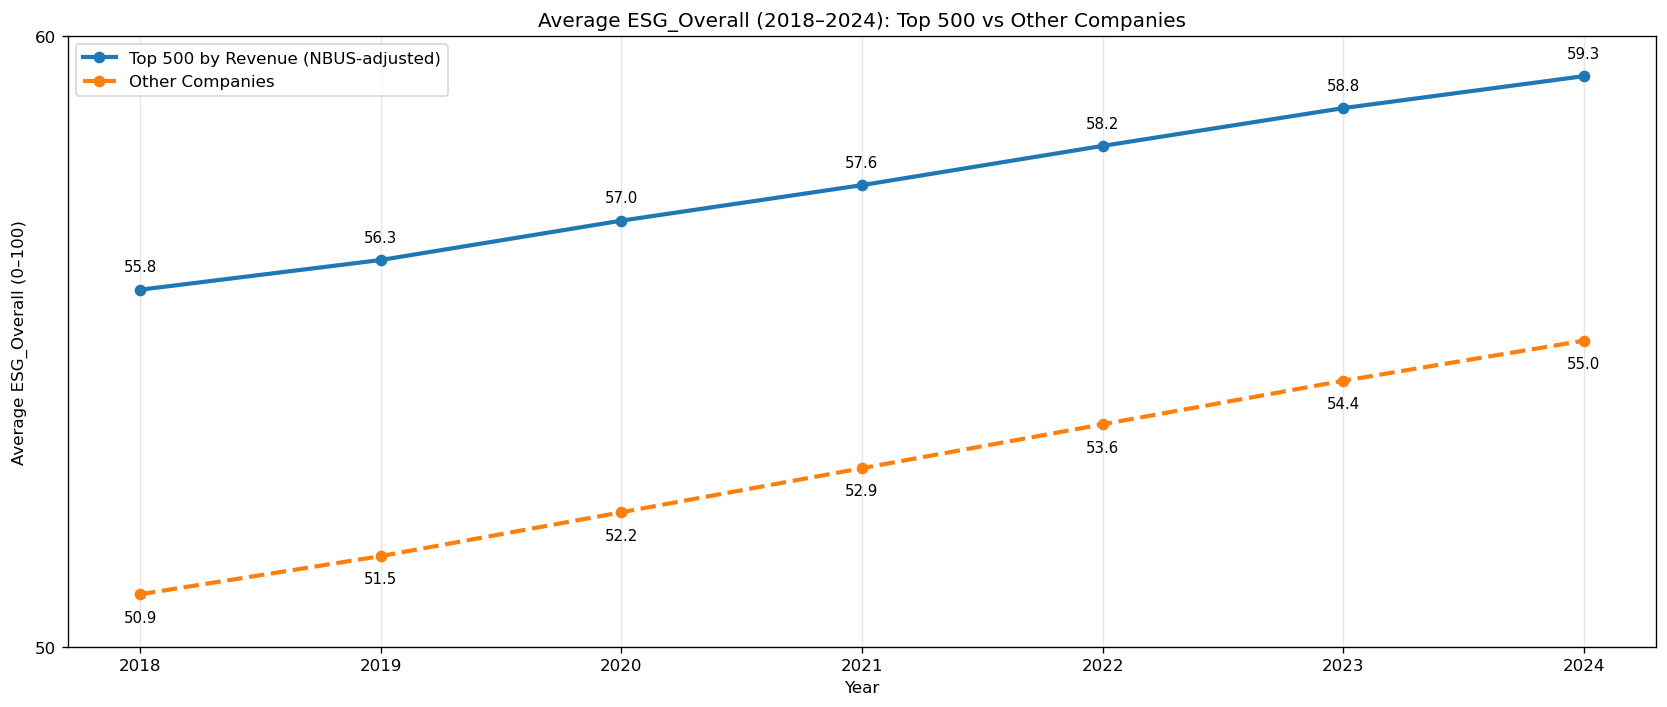

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "company_esg_financial_dataset.csv"
START_YEAR, END_YEAR = 2018, 2024
YEARS = list(range(START_YEAR, END_YEAR + 1))
TOP_N = 500

NBUS = {
    2018: 112.60555,
    2019: 115.21865,
    2020: 113.1493,
    2021: 113.2556,
    2022: 118.43175,
    2023: 120.4265,
    2024: 124.55225
}

# Load & clean

df = pd.read_csv(FILE)

company_col = "CompanyID" if "CompanyID" in df.columns else "CompanyName"

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")
df["ESG_Overall"] = pd.to_numeric(df["ESG_Overall"], errors="coerce")

df = df.dropna(subset=["Year", "Revenue", "ESG_Overall", company_col]).copy()
df = df[df["Year"].between(START_YEAR, END_YEAR)].copy()

df["ESG_Overall"] = df["ESG_Overall"].clip(0, 100)


# NBUS adjustment

df["NBUS"] = df["Year"].map(NBUS)
df = df.dropna(subset=["NBUS"]).copy()

df["Revenue_Real_2024"] = df["Revenue"] * (NBUS[2024] / df["NBUS"])

# Select Top 500 companies (by avg NBUS revenue)

top500_ids = (
    df.groupby(company_col)["Revenue_Real_2024"]
      .mean()
      .sort_values(ascending=False)
      .head(TOP_N)
      .index
)

df_top = df[df[company_col].isin(top500_ids)].copy()
df_other = df[~df[company_col].isin(top500_ids)].copy()


# Yearly average ESG (Top500 vs Other)


avg_top = (
    df_top.groupby("Year")["ESG_Overall"]
          .mean()
          .reindex(YEARS)
)

avg_other = (
    df_other.groupby("Year")["ESG_Overall"]
            .mean()
            .reindex(YEARS)
)


# Auto y-limit to nearest 10s band based on plotted values // min=51 -> 50, max=62 -> 70

vals = pd.concat([avg_top, avg_other]).dropna()
ymin = np.floor(vals.min() / 10) * 10
ymax = np.ceil(vals.max() / 10) * 10



if ymax - ymin < 10:
    ymax = ymin + 10


# Plot

plt.figure(figsize=(14, 6))

plt.plot(YEARS, avg_top.values, marker="o", linewidth=2.5, label=f"Top {TOP_N} by Revenue (NBUS-adjusted)")
plt.plot(YEARS, avg_other.values, marker="o", linestyle="--", linewidth=2.5, label="Other Companies")

# Value labels

for y in YEARS:
    v1 = avg_top.loc[y]
    v2 = avg_other.loc[y]

    if pd.notna(v1):
        plt.text(y, v1 + 0.25, f"{v1:.1f}", ha="center", va="bottom", fontsize=9)
    if pd.notna(v2):
        plt.text(y, v2 - 0.25, f"{v2:.1f}", ha="center", va="top", fontsize=9)

plt.title(f"Average ESG_Overall (2018–2024): Top {TOP_N} vs Other Companies")
plt.xlabel("Year")
plt.ylabel("Average ESG_Overall (0–100)")
plt.ylim(ymin, ymax)
plt.yticks(np.arange(ymin, ymax + 1, 10))  # 10'luk metrik
plt.xticks(YEARS)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


##### Average  Resource Consumptions and C02 Release

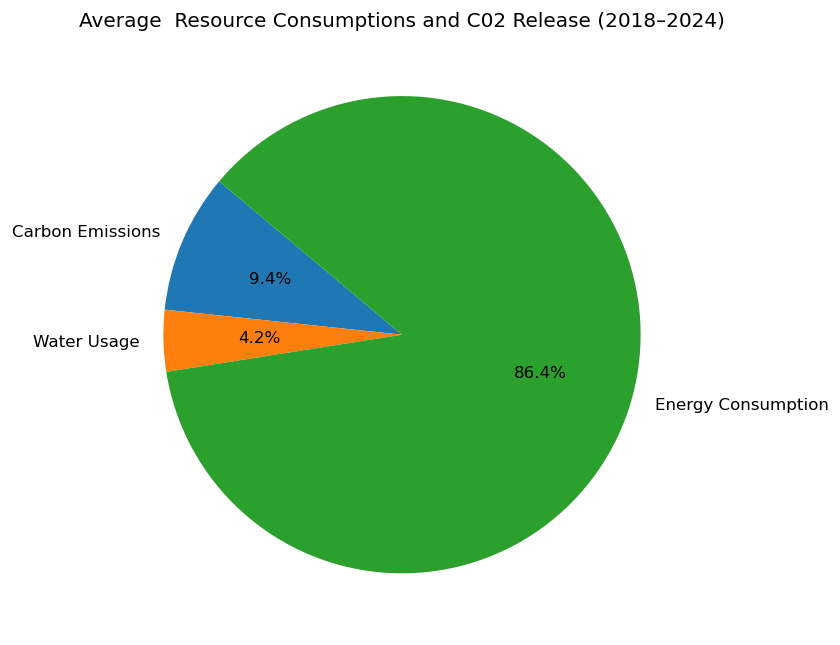

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

FILE = "company_esg_financial_dataset.csv"
START_YEAR, END_YEAR = 2018, 2024

df = pd.read_csv(FILE)


# Filter years

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df[df["Year"].between(START_YEAR, END_YEAR)].copy()


# Select and clean columns

cols = ["CarbonEmissions", "WaterUsage", "EnergyConsumption"]
for c in cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=cols)


# Average values (2018–2024)

avg_values = df[cols].mean()

# Convert to percentage share
percent_share = (avg_values / avg_values.sum()) * 100


# Pie chart

plt.figure(figsize=(7, 7))
plt.pie(
    percent_share,
    labels=[
        "Carbon Emissions",
        "Water Usage",
        "Energy Consumption"
    ],
    autopct="%1.1f%%",
    startangle=140
)

plt.title("Average  Resource Consumptions and C02 Release (2018–2024)")
plt.tight_layout()
plt.show()


##### Top 500 Companies' Share of Total Resource Consumption


Top 500 Share of Total Consumption (2018–2024):

                   Top 500 Share (%)
CarbonEmissions                86.35
WaterUsage                     81.29
EnergyConsumption              87.72


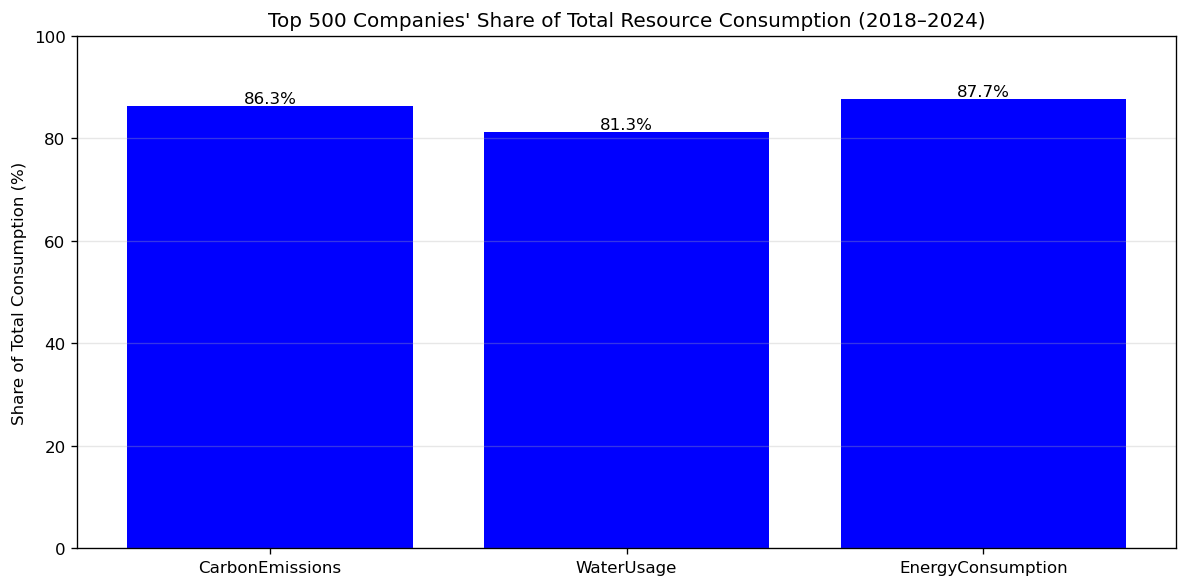

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "company_esg_financial_dataset.csv"
START_YEAR, END_YEAR = 2018, 2024
TOP_N = 500

NBUS = {
    2018: 112.60555,
    2019: 115.21865,
    2020: 113.1493,
    2021: 113.2556,
    2022: 118.43175,
    2023: 120.4265,
    2024: 124.55225
}

df = pd.read_csv(FILE)


# Filter years + numeric clean

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df[df["Year"].between(START_YEAR, END_YEAR)].copy()

num_cols = ["Revenue", "CarbonEmissions", "WaterUsage", "EnergyConsumption"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["CompanyID", "Revenue"])

# NBUS adjusted revenue

df["NBUS"] = df["Year"].map(NBUS)
df["Revenue_2024"] = df["Revenue"] * (NBUS[2024] / df["NBUS"])


# Select Top 500 companies

top500_ids = (
    df.groupby("CompanyID")["Revenue_2024"]
      .sum()
      .sort_values(ascending=False)
      .head(TOP_N)
      .index
)

df_top = df[df["CompanyID"].isin(top500_ids)].copy()


# Aggregate totals (2018–2024)

metrics = ["CarbonEmissions", "WaterUsage", "EnergyConsumption"]

total_all = df[metrics].sum()
total_top = df_top[metrics].sum()

share_pct = (total_top / total_all) * 100


# Numeric output

summary = pd.DataFrame({

    "Top 500 Share (%)": share_pct
}).round(2)

print("\nTop 500 Share of Total Consumption (2018–2024):\n")
print(summary)


# Bar chart (% share)

plt.figure(figsize=(10, 5))
plt.bar(summary.index, summary["Top 500 Share (%)"], color="blue")

for i, v in enumerate(summary["Top 500 Share (%)"]):
    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom", fontsize=10)

plt.title("Top 500 Companies' Share of Total Resource Consumption (2018–2024)")
plt.ylabel("Share of Total Consumption (%)")
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
